In [1]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from datacube.helpers import write_geotiff
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import display_map
from dea_plotting import rgb
from dea_classificationtools import predict_xr
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics

import numpy as np
import xarray as xr
from sklearn.model_selection import GridSearchCV
import pickle

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
dc = datacube.Datacube(app="L8_single_WCF")

## Select Location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [3]:
# Set the central latitude and longitude
central_lat = -36.72 
central_lon = 149.95

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
lats = (central_lat - buffer, central_lat + buffer)
lons = (central_lon - buffer, central_lon + buffer)

display_map(x=lons, y=lats, margin=-0.2)

../Scripts/dea_plotting.py:318: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_x, all_y)


In [4]:
#list(dc.list_products()['name'])

In [5]:
fire_date = '2018-03-18'
time_step = timedelta(days=120)

# Calculate the start and end date for baseline data load
start_date_pre = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-time_step), '%Y-%m-%d')
end_date_pre = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-timedelta(days=1)), '%Y-%m-%d')

# Calculate end date for post fire data load
start_date_post = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))+timedelta(days=1)), '%Y-%m-%d')
end_date_post = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))+timedelta(days=15)), '%Y-%m-%d')

# Print dates
print('start_date_pre:  '+start_date_pre)
print('end_date_pre:    '+end_date_pre) # if end date is exclusive, just use fire_date
print('fire_date:       '+fire_date)
print('start_date_post: '+start_date_post)
print('end_date_post:   '+end_date_post)

start_date_pre:  2017-11-18
end_date_pre:    2018-03-17
fire_date:       2018-03-18
start_date_post: 2018-03-19
end_date_post:   2018-04-02


In [8]:
products = ['ga_ls8c_ard_3']
measurements = ['nbart_blue','nbart_green','nbart_red','nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
resolution=(-30, 30)

### Before

In [9]:
# Load all data before fire
before =  load_ard(dc=dc,
                   products=products,
                   x=lons,
                   y=lats,
                   time=(start_date_pre, end_date_pre),
                   measurements=measurements,
                   min_gooddata=0.5,
                   output_crs='EPSG:3577',
                   resolution=resolution
            #      dask_bs = {'x': 500, 'y': 500},
            #      group_by='solar_day'
                   )


Finding datasets
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 8 out of 30 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 8 time steps


/env/lib/python3.6/site-packages/odc/algo/_masking.py:51: PendingDeprecationWarning: Dataset.apply may be deprecated in the future. Using Dataset.map is encouraged
  keep_attrs=True)
/env/lib/python3.6/site-packages/odc/algo/_masking.py:148: PendingDeprecationWarning: Dataset.apply may be deprecated in the future. Using Dataset.map is encouraged
  keep_attrs=True)


In [10]:
before

<xarray.Dataset>
Dimensions:       (time: 8, x: 695, y: 815)
Coordinates:
  * time          (time) datetime64[ns] 2017-11-23T23:50:53.251767 ... 2018-0...
  * y             (y) float64 -4.114e+06 -4.114e+06 ... -4.138e+06 -4.138e+06
  * x             (x) float64 1.592e+06 1.592e+06 ... 1.612e+06 1.612e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (time, y, x) float32 359.0 420.0 424.0 ... 391.0 365.0 336.0
    nbart_green   (time, y, x) float32 608.0 702.0 719.0 ... 240.0 214.0 190.0
    nbart_red     (time, y, x) float32 513.0 639.0 607.0 ... 172.0 153.0 139.0
    nbart_nir     (time, y, x) float32 2683.0 2906.0 3106.0 ... 147.0 129.0
    nbart_swir_1  (time, y, x) float32 2050.0 2457.0 2493.0 ... 110.0 100.0
    nbart_swir_2  (time, y, x) float32 1124.0 1403.0 1311.0 ... 121.0 103.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

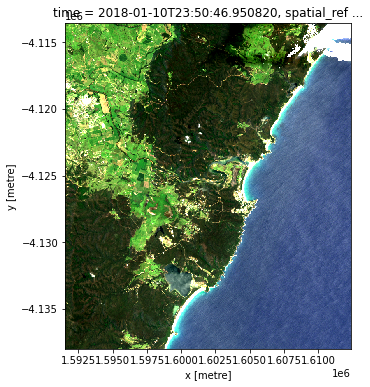

In [12]:
# Visualise before image as  true colour image
rgb(before.isel(time=4), bands=['nbart_red', 'nbart_green', 'nbart_blue']) # 10-01-2018

In [13]:
before_im = before.isel(time=4)

### After

In [14]:
start_date_post, end_date_post

('2018-03-19', '2018-04-02')

In [16]:
# Load all data before fire
after =  load_ard(dc=dc,
                  products=products,
                  x=lons,
                  y=lats,
                  time=(start_date_post, '2018-06-01'),
                  measurements=measurements,
                  min_gooddata=0.5,
                  output_crs='EPSG:3577',
                  resolution=resolution
            #     dask_bs = {'x': 500, 'y': 500},
            #     group_by='solar_day'
                  )


Finding datasets
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 5 out of 18 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 5 time steps


/env/lib/python3.6/site-packages/odc/algo/_masking.py:51: PendingDeprecationWarning: Dataset.apply may be deprecated in the future. Using Dataset.map is encouraged
  keep_attrs=True)
/env/lib/python3.6/site-packages/odc/algo/_masking.py:148: PendingDeprecationWarning: Dataset.apply may be deprecated in the future. Using Dataset.map is encouraged
  keep_attrs=True)


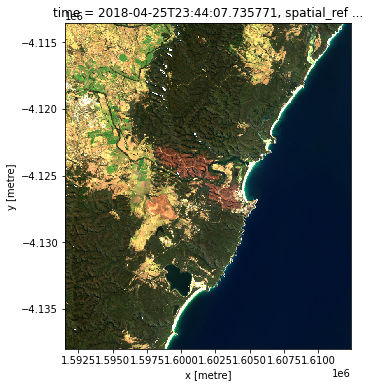

In [17]:
# Visualise after image as  true colour image
rgb(after.isel(time=2), bands=['nbart_red', 'nbart_green', 'nbart_blue']) # 2 is good, 4? 5 best! (25-04-2018)

In [18]:
after_im = after.isel(time=2)
after_im

<xarray.Dataset>
Dimensions:       (x: 695, y: 815)
Coordinates:
    time          datetime64[ns] 2018-04-25T23:44:07.735771
  * y             (y) float64 -4.114e+06 -4.114e+06 ... -4.138e+06 -4.138e+06
  * x             (x) float64 1.592e+06 1.592e+06 ... 1.612e+06 1.612e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (y, x) float32 314.0 370.0 417.0 352.0 ... 281.0 283.0 277.0
    nbart_green   (y, x) float32 435.0 550.0 631.0 526.0 ... 172.0 175.0 169.0
    nbart_red     (y, x) float32 517.0 565.0 876.0 704.0 ... 94.0 105.0 99.0
    nbart_nir     (y, x) float32 1949.0 2282.0 2304.0 2240.0 ... 55.0 55.0 56.0
    nbart_swir_1  (y, x) float32 1612.0 1797.0 2787.0 2189.0 ... 28.0 31.0 26.0
    nbart_swir_2  (y, x) float32 755.0 997.0 1475.0 1133.0 ... 24.0 25.0 25.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Get model

In [19]:
pickle_in = open('../Gabrielle/pickled.pickle','rb')
model = pickle.load(pickle_in)
print(model)

RandomForestRegressor(min_samples_leaf=50, random_state=30)


/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Predict WCF on image

Define a function to format image and run model over it

In [20]:
def predict_wcf(image,model):
    flat = sklearn_flatten(image)
    flat = flat/10000
    results = model.predict(flat)
    unflat = (sklearn_unflatten(results,image).transpose())[0]
    return unflat

In [21]:
wcf_before = predict_wcf(before_im,model)
wcf_after = predict_wcf(after_im,model)

In [22]:
before_im

<xarray.Dataset>
Dimensions:       (x: 695, y: 815)
Coordinates:
    time          datetime64[ns] 2018-01-10T23:50:46.950820
  * y             (y) float64 -4.114e+06 -4.114e+06 ... -4.138e+06 -4.138e+06
  * x             (x) float64 1.592e+06 1.592e+06 ... 1.612e+06 1.612e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (y, x) float32 323.0 348.0 351.0 305.0 ... 598.0 598.0 600.0
    nbart_green   (y, x) float32 589.0 661.0 666.0 482.0 ... 428.0 434.0 435.0
    nbart_red     (y, x) float32 465.0 500.0 485.0 401.0 ... 369.0 377.0 379.0
    nbart_nir     (y, x) float32 2750.0 3023.0 3502.0 ... 375.0 382.0 379.0
    nbart_swir_1  (y, x) float32 2069.0 2255.0 2129.0 ... 300.0 313.0 307.0
    nbart_swir_2  (y, x) float32 929.0 1096.0 956.0 757.0 ... 257.0 266.0 261.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Plot the results

Woody cover in training data varies between 0 and 1

In [23]:
wcf_before

<xarray.DataArray (x: 695)>
array([0.26727394, 0.08911152, 0.08740618, 0.41749845, 0.4988634 ,
       0.37512786, 0.12578283, 0.4948704 , 0.03159099, 0.01159026,
       0.01441393, 0.03300652, 0.03264563, 0.02775306, 0.03329719,
       0.03808258, 0.04395418, 0.03695708, 0.01084057, 0.012664  ,
       0.03027955, 0.26935844, 0.26935844, 0.46126021, 0.28236935,
       0.47100599, 0.87190715, 0.90788959, 0.38004351, 0.36890317,
       0.70741351, 0.73343924, 0.91478916, 0.45407033, 0.16874002,
       0.13634986, 0.13828489, 0.34019406, 0.36043159, 0.13919968,
       0.10758536, 0.12955907, 0.29918554, 0.05188341, 0.05153626,
       0.03320099, 0.04563447, 0.03574656, 0.04147341, 0.03098932,
       0.01579276, 0.03886244, 0.04307802, 0.00878438, 0.02654132,
       0.07266452, 0.09086376, 0.04654327, 0.03264563, 0.02756483,
       0.04305852, 0.14368887, 0.33267895, 0.13661091, 0.1376518 ,
       0.10832734, 0.09400935, 0.0436309 , 0.08170721, 0.06791868,
       0.03468625, 0.10526169, 0.43462383, 0.12099973, 0.12106378,
       0.10912797, 0.11167934, 0.11167934, 0.11167934, 0.21509914,
       0.31478071, 0.06067222, 0.33185556, 0.36380092, 0.29311153,
       0.07825104, 0.03376447, 0.12174376, 0.12174376, 0.06338301,
       0.03886244, 0.04469877, 0.04484736, 0.01429927, 0.00833449,
       0.0110398 , 0.00776812, 0.02669665, 0.03178272, 0.11071354,
...
       0.09127379,        nan,        nan, 0.08962965,        nan,
       0.08217008,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.58560974, 0.62596465, 0.5864276 , 0.54298004, 0.49008598,
              nan, 0.73523132, 0.68272721, 0.82859991, 0.85417288,
       0.80284122, 0.67254467,        nan, 0.68242992,        nan,
       0.64337594, 0.66824829, 0.67441545, 0.6700307 , 0.68321882,
       0.75630393, 0.75971814, 0.67636739, 0.63894703, 0.67290524,
       0.78450562, 0.68072917, 0.65059282,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])
Coordinates:
  * x        (x) float64 1.592e+06 1.592e+06 1.592e+06 ... 1.612e+06 1.612e+06
    y        float64 -4.114e+06

Exception: The input dataset `ds` has more than two dimensions: ['time', 'x', 'y']. Please select a single observation using e.g. `index=0`, or enable faceted plotting by adding the arguments e.g. `col="time", col_wrap=4` to the function call

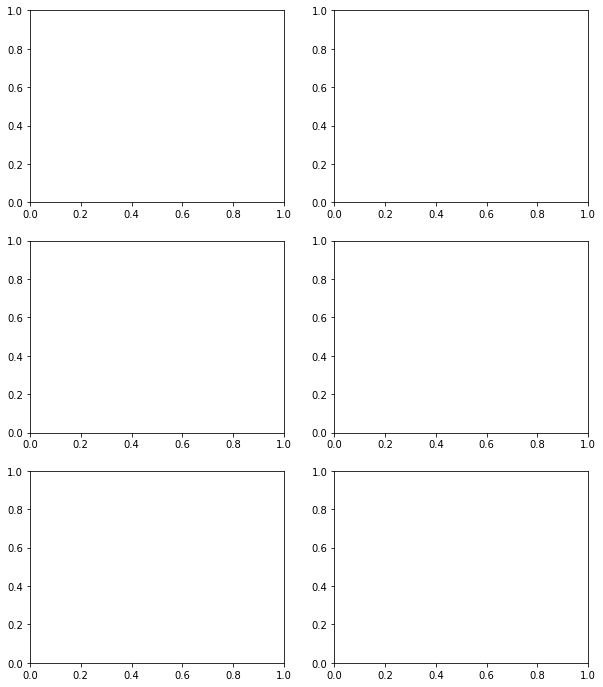

In [31]:
# Set up subplots
f, ax = plt.subplots(3, 2, figsize=(10,12), squeeze=False)

# before images
rgb(before, bands=['nbart_red', 'nbart_green', 'nbart_blue'], ax=ax[0,0])
wcf_before.plot(ax=ax[1,0],vmin=0,vmax=1)
(wcf_before>0.1).plot(ax=ax[2,0],vmin=0,vmax=1)

# after images
rgb(after, bands=['nbart_red', 'nbart_green', 'nbart_blue'], ax=ax[0,1])
wcf_after.plot(ax=ax[1,1],vmin=0,vmax=1)
(wcf_after>0.1).plot(ax=ax[2,1],vmin=0,vmax=1)